In [1]:
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms as T

from adabelief_pytorch import AdaBelief

from torchvision.utils import make_grid

import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random
import pickle

from scripts.unet import UNet
from PIL import Image

import wandb

In [2]:
class CardDataset(Dataset):
    def __init__(self, path):
        self._dataset = pickle.load(open(path,'rb'))
        self._images = self._dataset["data"]
        self._gt = self._dataset["gt"]
        self._info = self._dataset["info"]
        
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, idx):
        im = Image.fromarray(self._images[idx])
        self.trans = T.Compose([
            T.ToTensor()
        ])
        im_t = self.trans(im)
        return im_t, torch.tensor(self._gt[idx])

In [3]:
dataset = CardDataset("../data/PCSE/release/scenes/scenes_extralarge.pck")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, pin_memory=True)

In [4]:
def show_batch(dl):
    for images, masks in dl:
        fig, ax = plt.subplots(figsize=(16, 18))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:10], nrow=5).permute(1, 2, 0))
        mask_grid = make_grid(masks[:10].reshape(10,1,256,256), nrow=5).permute(1, 2, 0)
        break
    return mask_grid

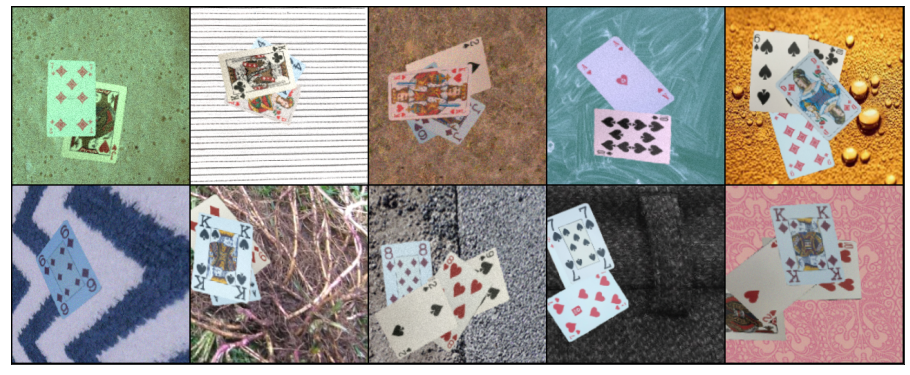

In [5]:
g = show_batch(dataloader)

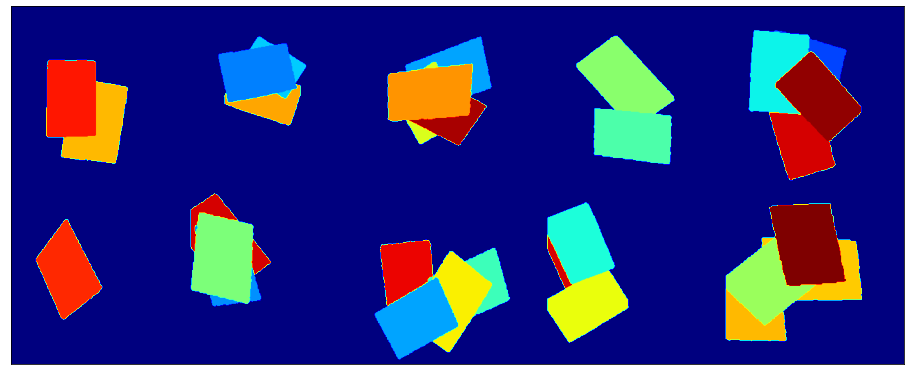

In [6]:
fig, ax = plt.subplots(figsize=(16, 18))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(g[:,:,0], cmap="jet")

In [7]:
wandb.login()

wandb: Currently logged in as: neonode (use `wandb login --relogin` to force relogin)


True

In [8]:
run = wandb.init(project='card-segmentation') 

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, n_classes=53, wf=5, depth=4, padding=True, up_mode='upsample').to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load(f'../results/unet_50_comp_large.pt'))

<All keys matched successfully>

In [36]:
epochs = 150

phase = "train"

for epoch in range(epochs):
    total_loss = 0
    progress = tqdm(enumerate(dataloader), desc="Loss: ")
    
    model.train()
    
    for i, (X, target) in progress:
        X = X.float().to(device)  # [N, 3, H, W]
        target = target.long().to(device)  # [N, H, W] with class indices (0, 1)
        
        outputs = model(X) # [N, 1, H, W]
        
        loss = criterion(outputs, target)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        current_loss = loss.item()
        total_loss += current_loss
        
        out_max = torch.argmax(outputs, dim=1, keepdim=True)
        
        log_dict = {f"{phase}/loss": total_loss/(i+1)}
        if i % 100 == 0:
            mask = out_max[0][0].detach().cpu().numpy()
            labels = {v: k for k, v in dataset._info["labels"].items()}
            log_dict[f"{phase}/train_examples"] = wandb.Image(X[0].permute(1,2,0).cpu().numpy(), masks={
                "prediction": {"mask_data": mask, "class_labels": labels},
                "ground truth": {"mask_data": target[0].cpu().numpy(), "class_labels": labels}
            })
        
        progress.set_description(f"Epoch: {epoch} | Loss: {(total_loss/(i+1))}")
        
        wandb.log(log_dict)
        
    torch.cuda.empty_cache() 
    val_losses = 0

wandb.run.finish()
torch.save(model.state_dict(), f'../results/unet_{epochs}_comp_large.pt')

Epoch: 0 | Loss: 0.06366533144116401: : 625it [01:57,  5.34it/s] 
Epoch: 1 | Loss: 0.06311256012320518: : 625it [01:54,  5.48it/s] 
Epoch: 2 | Loss: 0.06087225387394428: : 625it [01:54,  5.47it/s] 
Epoch: 3 | Loss: 0.06547713204324246: : 625it [01:54,  5.48it/s] 
Epoch: 4 | Loss: 0.058379183024168016: : 625it [01:53,  5.52it/s]
Epoch: 5 | Loss: 0.07405622861683368: : 625it [01:53,  5.52it/s] 
Epoch: 6 | Loss: 0.049398586404323576: : 625it [01:53,  5.51it/s]
Epoch: 7 | Loss: 0.05746264547407627: : 625it [01:53,  5.51it/s] 
Epoch: 8 | Loss: 0.06412573351860046: : 625it [01:53,  5.50it/s] 
Epoch: 9 | Loss: 0.04785991781353951: : 625it [01:53,  5.52it/s] 
Epoch: 10 | Loss: 0.0524837747067213: : 625it [01:53,  5.51it/s]  
Epoch: 11 | Loss: 0.0604786570250988: : 625it [01:53,  5.51it/s]  
Epoch: 12 | Loss: 0.05232656945884228: : 625it [01:53,  5.52it/s] 
Epoch: 13 | Loss: 0.04591951255202294: : 625it [01:53,  5.53it/s] 
Epoch: 14 | Loss: 0.05594560883939266: : 625it [01:53,  5.52it/s] 
Epoch

train/loss,0.04805
_runtime,17579
_timestamp,1623927380
_step,93749


train/loss,▅▅▄▅▃▃▆▄█▆▅▆▂▄▃▁▂▆▃▄▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▃▄▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


In [ ]:
torch.save(model.state_dict(), f'../results/unet_{epochs}_comp_large.pt')